In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range
from abtem.waves import PlaneWave
from Column_matching import Bessel_transform
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)

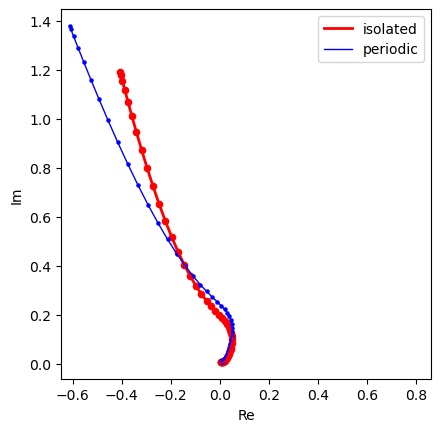

In [10]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 2
thickness = 10
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
krange = np.linspace(gmin+0.01, gmax, length)
structure_1 = Generate_structure.generate_column("Al", thickness, a, (n_repeat)*a)
#    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, 1, 1, thickness)
exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                        gmin, gmax, sampling)
m, n = exitwave_1.shape
exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave_1.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave_1)), exitwave_1.shape)
x = np.arange(0, m, 1) - x0; y = np.arange(0, n, 1) - y0
results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, 
                                       x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)

results1, components1 = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
#structure_2 = Generate_structure.generate_column("Al", thickness, a, a)
structure_2 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_2 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_2).array),
                        gmin, gmax, sampling)
m, n = exitwave_2.shape
exitwave_2 = exitwave_2[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
results2, components2 = Bessel_transform(exitwave_2-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
plt.plot(np.real(results1), np.imag(results1), color='r', linewidth=2, label="isolated")
plt.scatter(np.real(results1), np.imag(results1), color='r', s=20)
plt.plot(np.real(results2), np.imag(results2), color='b', linewidth=1, label="periodic")
plt.scatter(np.real(results2), np.imag(results2), color='b', s=5)
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.show()

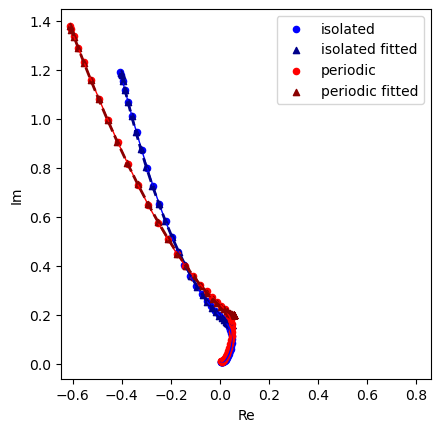

In [11]:
fitted_1 = Gaussian_fitting(results1, krange, [0.01, 1], defocus=True)
coeff1 = np.array(list(fitted_1.best_values.values()))
bg1 = coeff1[-2] + 1j*coeff1[-1]
#recover_1 = Gaussian_in_focus(krange, *coeff1)
recover_1 = Gaussian_function(krange, *coeff1)
fitted_2 = Gaussian_fitting(results2, krange, [0.01, 1], defocus=True)
coeff2 = np.array(list(fitted_2.best_values.values()))
#recover_2 = Gaussian_in_focus(krange, *coeff2)
recover_2 = Gaussian_function(krange, *coeff2)
bg2 = coeff2[-2] + 1j*coeff2[-1]
plt.plot(np.real(results1), np.imag(results1), color='b', linewidth=1)
plt.scatter(np.real(results1), np.imag(results1), color='b', s=20, label="isolated")
plt.plot(np.real(recover_1), np.imag(recover_1), '--', color='darkblue', linewidth=2)
plt.scatter(np.real(recover_1), np.imag(recover_1), marker="^", color='darkblue', s=20, label="isolated fitted")
plt.plot(np.real(results2), np.imag(results2), color='r', linewidth=1)
plt.scatter(np.real(results2), np.imag(results2), color='r', s=20, label="periodic")
plt.plot(np.real(recover_2), np.imag(recover_2), '--', color='darkred', linewidth=2)
plt.scatter(np.real(recover_2), np.imag(recover_2), marker="^", color='darkred', s=20, label="periodic fitted")
plt.xlabel("Re")
plt.ylabel("Im")
plt.legend()
plt.axis("square")
plt.show()

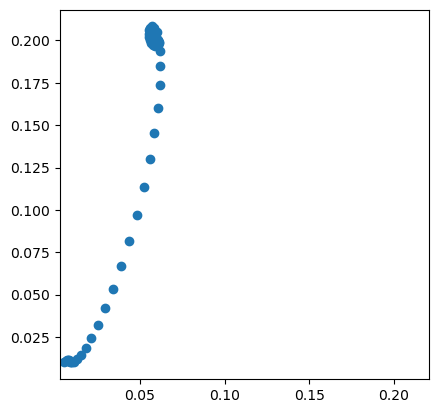

In [15]:
residue = results2-recover_2 + bg2
#residue = residue[krange>=1]
plt.scatter(np.real(residue), np.imag(residue))
plt.axis("square")
plt.show()

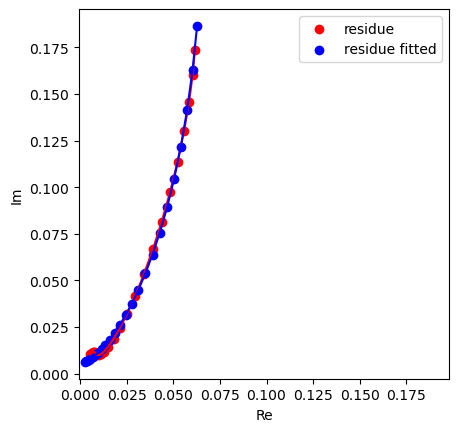

In [17]:
fitted_res = Gaussian_fitting(residue, krange, [1,gmax], defocus=True)
coeff_res = np.array(list(fitted_res.best_values.values()))
rec_res = Gaussian_function(krange, *coeff_res)
plt.scatter(np.real(residue[krange>=1]), np.imag(residue[krange>=1]), color='r', label='residue')
plt.plot(np.real(residue[krange>=1]), np.imag(residue[krange>=1]), color='r')
plt.scatter(np.real(rec_res[krange>=1]), np.imag(rec_res[krange>=1]), color='b', label='residue fitted')
plt.plot(np.real(rec_res[krange>=1]), np.imag(rec_res[krange>=1]), color='b')
plt.axis("square")
plt.legend()
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

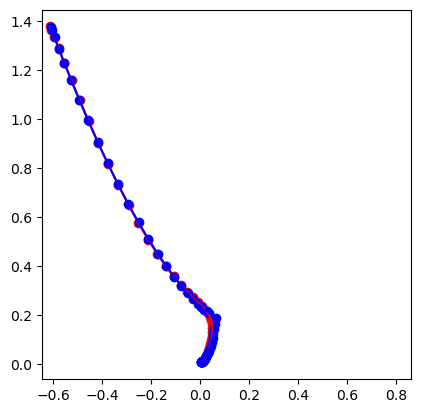

In [45]:
Gaussian_modified = np.where(krange<1, recover_2, rec_res+bg2)
plt.plot(np.real(results2), np.imag(results2), color='r')
plt.scatter(np.real(results2), np.imag(results2), color='r')
plt.plot(np.real(Gaussian_modified), np.imag(Gaussian_modified), color='b')
plt.scatter(np.real(Gaussian_modified), np.imag(Gaussian_modified), color='b')
plt.axis("square")
plt.show()

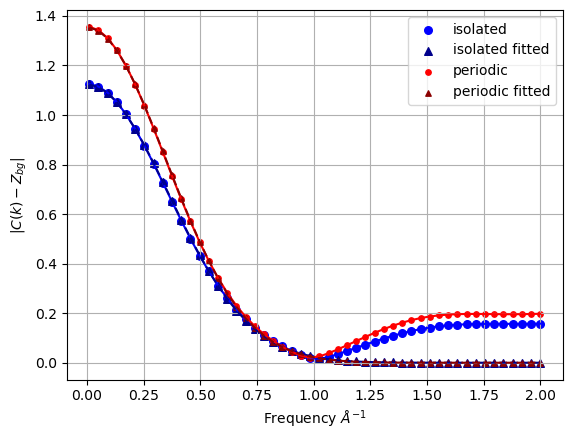

In [ ]:
plt.plot(krange, np.abs(results1-bg1), color='b')
plt.scatter(krange, np.abs(results1-bg1), color='b', s=30, label="isolated")
plt.plot(krange, np.abs(recover_1-bg1), '--', color='darkblue')
plt.scatter(krange, np.abs(recover_1-bg1), color='darkblue', marker='^',s=30, label="isolated fitted")
#plt.show()
plt.plot(krange, np.abs(results2-bg2), color='r')
plt.scatter(krange, np.abs(results2-bg2), color='r', s=15, label='periodic')
plt.plot(krange, np.abs(recover_2-bg2), '--', color='darkred')
plt.scatter(krange, np.abs(recover_2-bg2), color='darkred', marker='^',s=15, label='periodic fitted')
plt.legend()
plt.xlabel(r"Frequency $\AA^{-1}$")
plt.ylabel(r"|$C(k)-Z_{bg}$|")
plt.grid()
plt.show()

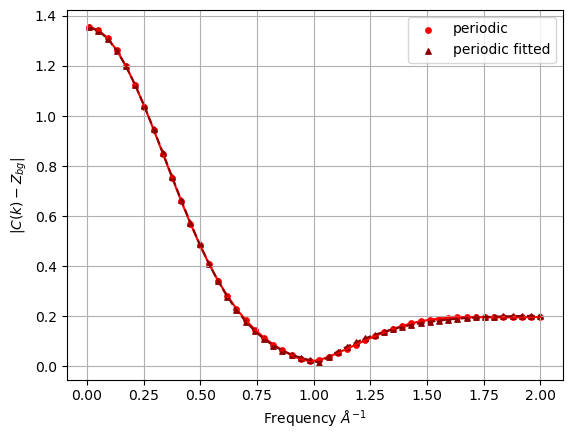

In [46]:
plt.plot(krange, np.abs(results2-bg2), color='r')
plt.scatter(krange, np.abs(results2-bg2), color='r', s=15, label='periodic')
plt.plot(krange, np.abs(Gaussian_modified-bg2), '--', color='darkred')
plt.scatter(krange, np.abs(Gaussian_modified-bg2), color='darkred', marker='^',s=15, label='periodic fitted')
plt.legend()
plt.xlabel(r"Frequency $\AA^{-1}$")
plt.ylabel(r"|$C(k)-Z_{bg}$|")
plt.grid()
plt.show()